Código para Dataset de Circulación

In [20]:
# Importamos librerias:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
# Leemos el dataset
data = pd.read_csv("/content/applemobilitytrends-2021-07-23.csv", sep=",")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
# Nos quedamos con las series de Argentina, serie_d = driving, serie_w = walking
data=data[data["region"]=="Argentina"]
dates = data.columns[6:]
data_d = data[data["transportation_type"]=="driving"]
data_w = data[data["transportation_type"]=="walking"]
serie_d=pd.DataFrame(data=data_d.iloc[0:,6:].transpose())
serie_w=pd.DataFrame(data=data_w.iloc[0:,6:].transpose())
serie_d = serie_d.rename(columns={2: 'Value'})
serie_w = serie_d.rename(columns={3: 'Value'})
serie_d.index = pd.to_datetime(serie_d.index)
serie_w.index = pd.to_datetime(serie_w.index)

In [23]:
# Interpolamos valores faltantes:
serie_d=serie_d.interpolate()
serie_w=serie_w.interpolate()


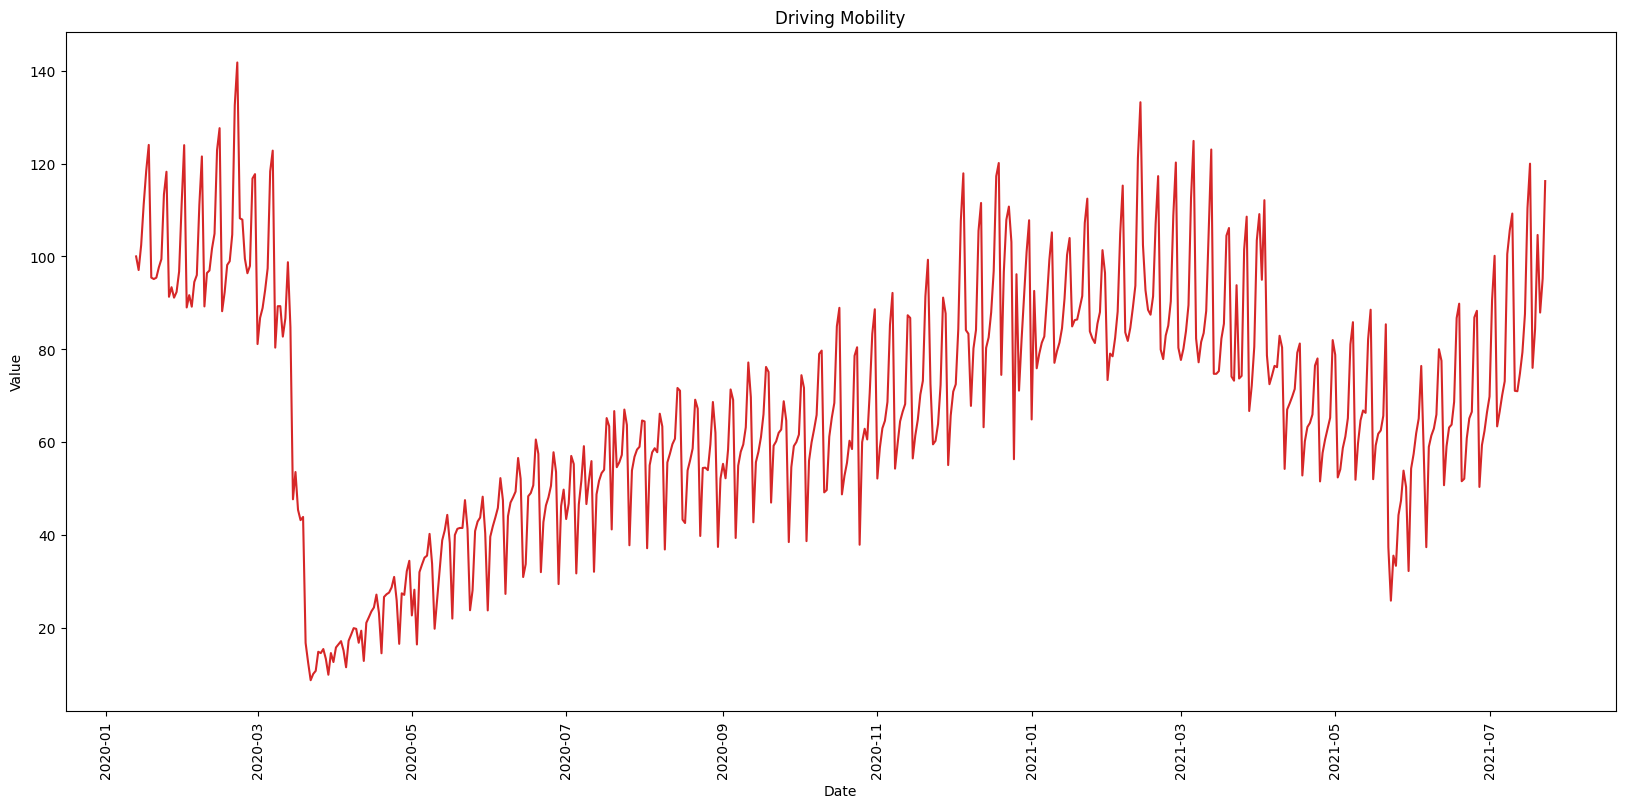

In [24]:
# Gráfico Driving
def plot_data(data, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(20,9), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.xticks(rotation=90)
    plt.savefig("Image.png")
    plt.show()
plot_data(serie_d, x=serie_d.index, y=serie_d.Value, title='Driving Mobility')

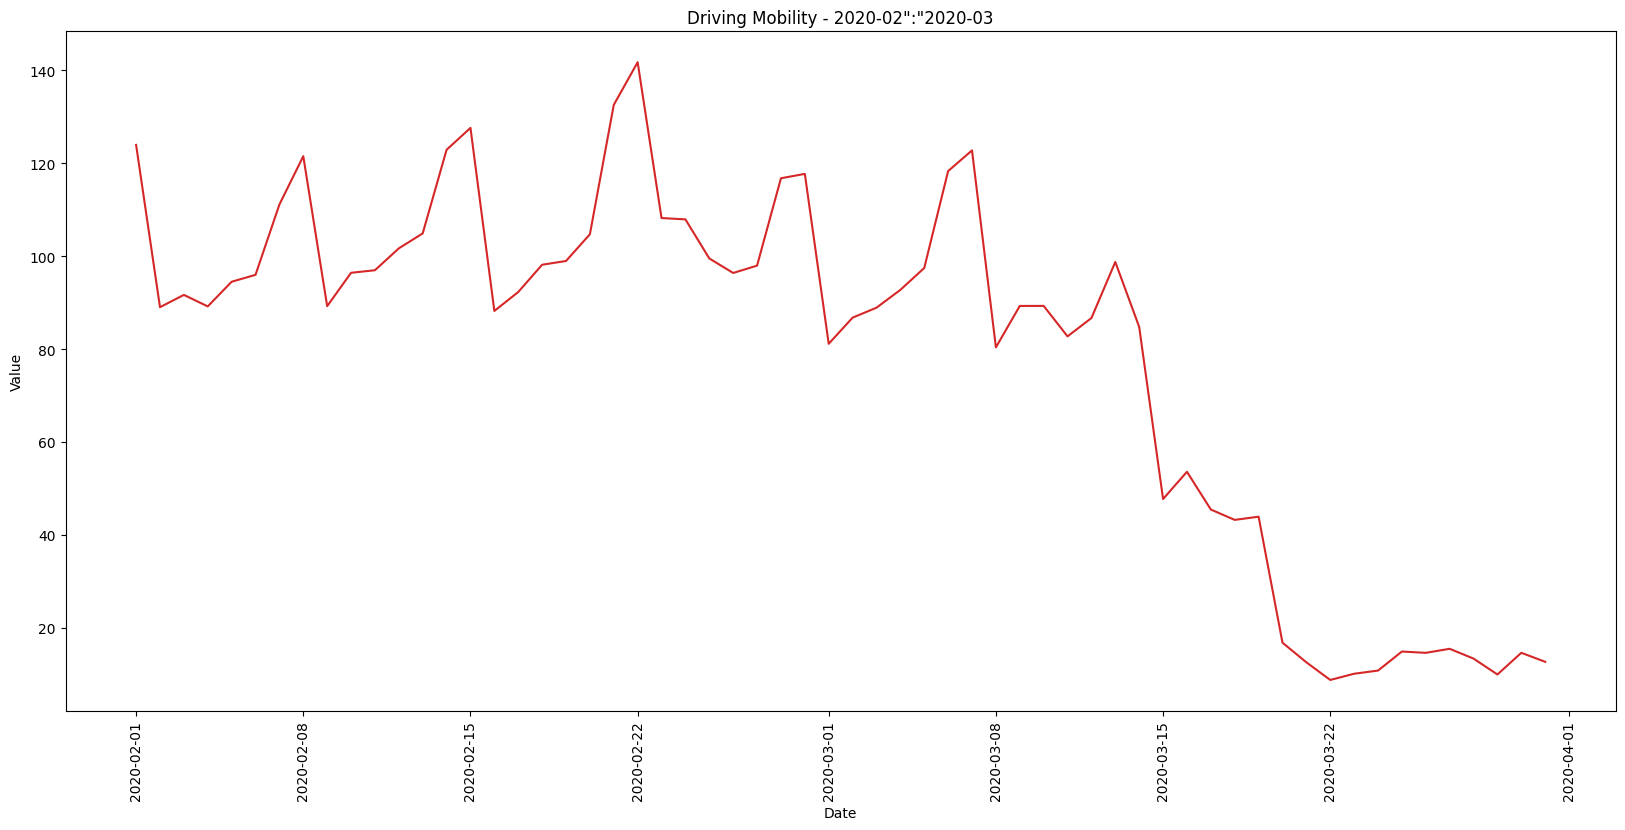

In [25]:
# Zoom sobre la fecha de la primer caida:
plot_data(serie_d.loc["2020-02-01":"2020-03-31"], x=serie_d.loc["2020-02-01":"2020-03-31"].index, y=serie_d.loc["2020-02-01":"2020-03-31"].Value, title='Driving Mobility - 2020-02":"2020-03')

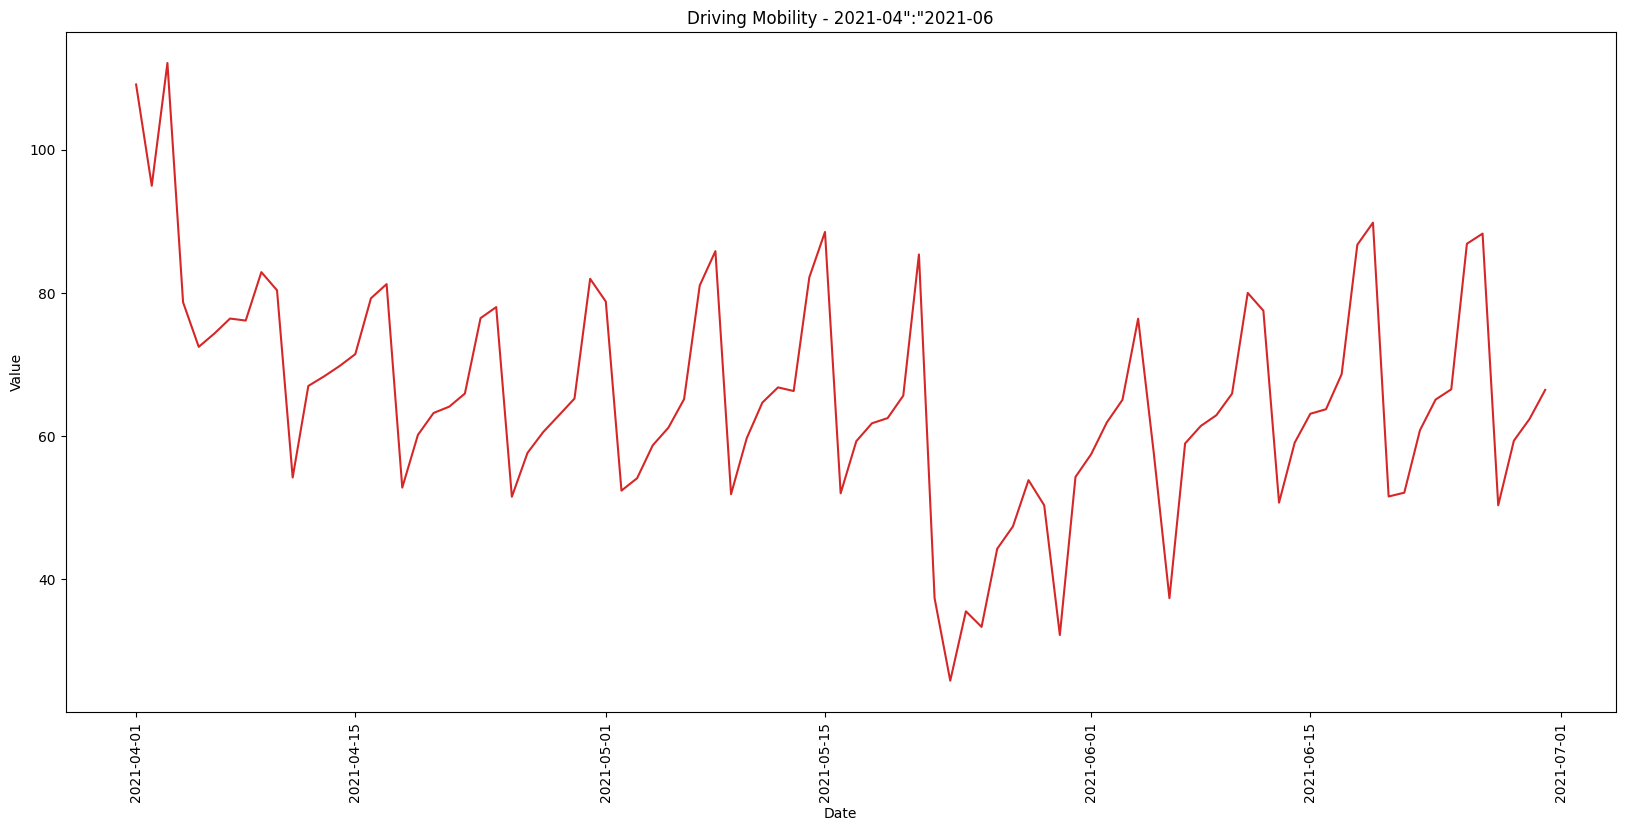

In [26]:
# Zoom sobre la fecha de la segunda caida:
plot_data(serie_d.loc["2021-04-01":"2021-06-30"], x=serie_d.loc["2021-04-01":"2021-06-30"].index, y=serie_d.loc["2021-04-01":"2021-06-30"].Value, title='Driving Mobility - 2021-04":"2021-06')

In [27]:
# Agregamos días de la semana:
serie_d['Weekday'] = pd.DatetimeIndex(serie_d.index).to_series().dt.day_name()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


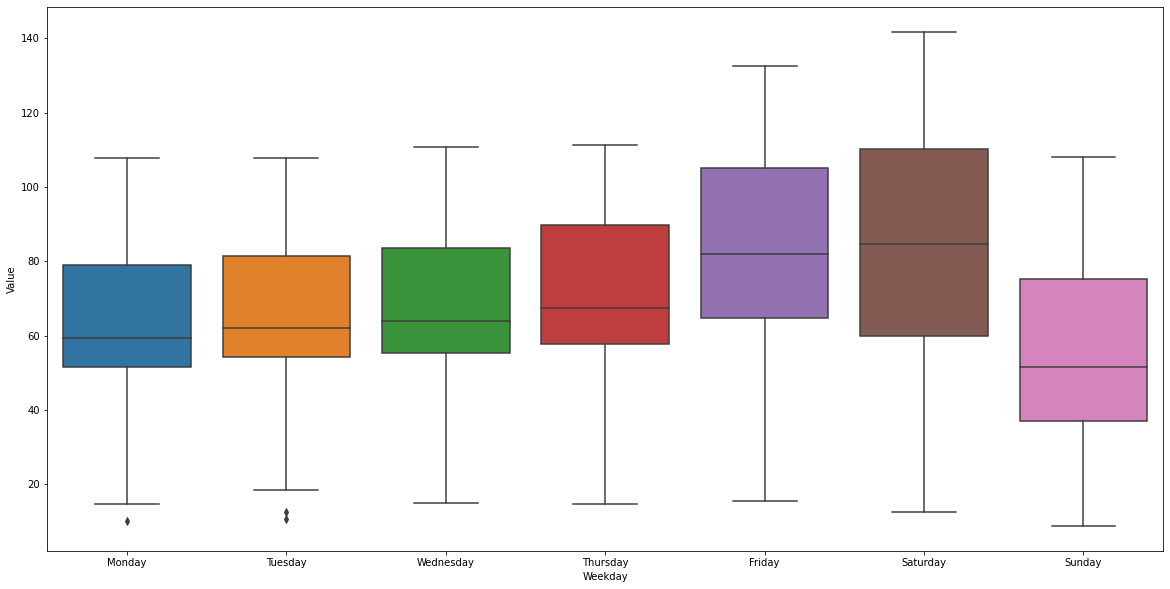

In [28]:
# Graficamos boxplot:
import seaborn
fig, ax = plt.subplots(figsize=(20,10))
seaborn.boxplot(serie_d.Weekday, serie_d.Value, ax=ax)
plt.savefig("boxplot.png")

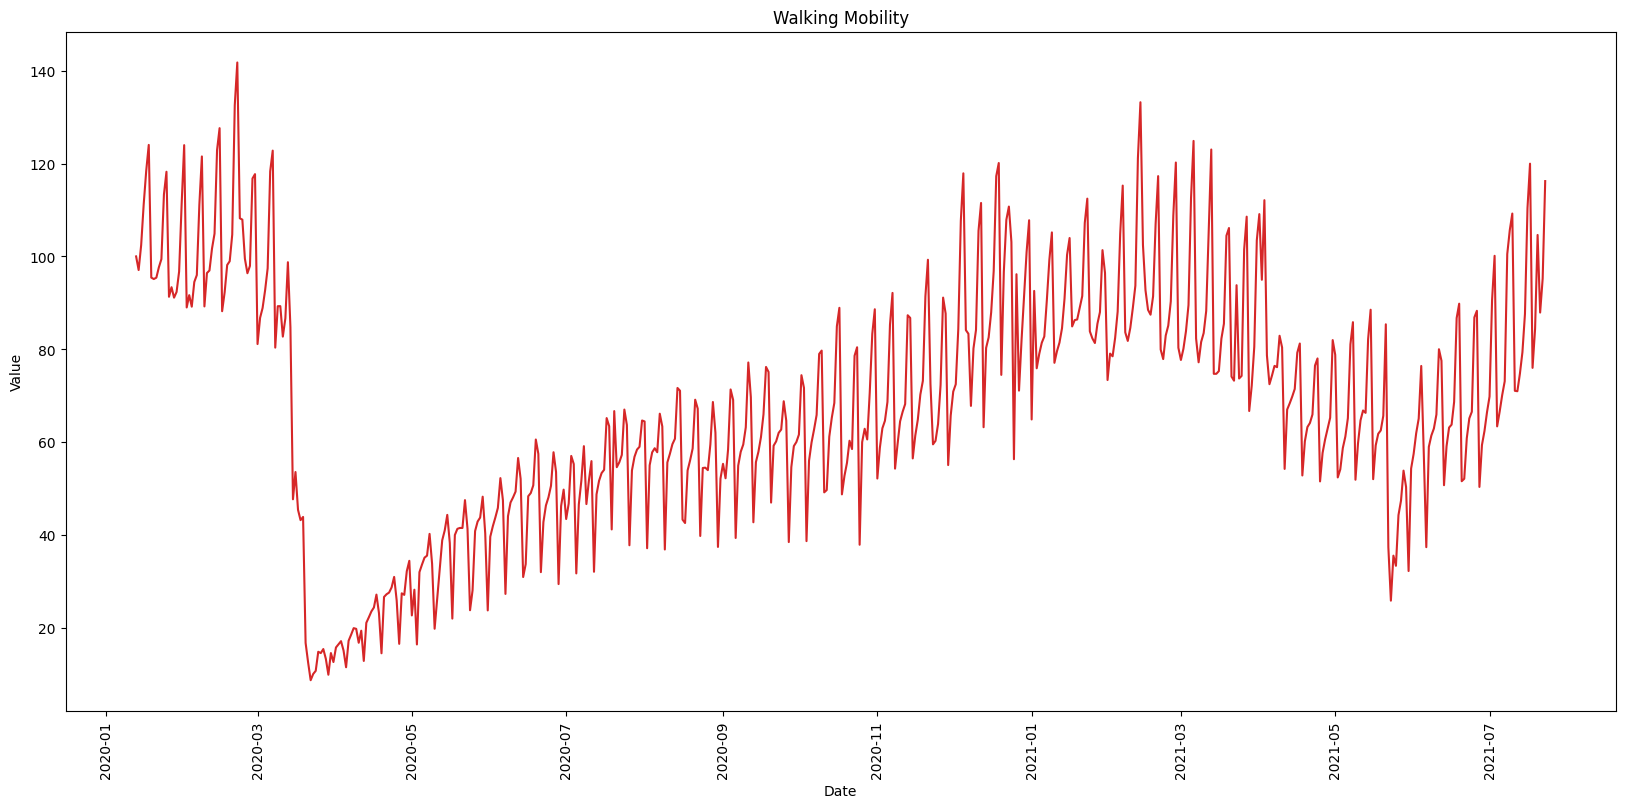

In [29]:
# Gráficamos Walking
def plot_data(data, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(20,9), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.xticks(rotation=90)
    plt.savefig("Image.png")
    plt.show()
plot_data(serie_w, x=serie_w.index, y=serie_w.Value, title='Walking Mobility')

In [30]:
# Vemos que el comportamiento es similar a driving, por lo tanto vamos a seguir trabajando con la serie driving.

In [31]:
# Conviertimos en array para realizar tests de estacionariedad
serie_d = serie_d.drop(labels="Weekday", axis=1)
serie_d_array = serie_d.loc[:, 'Value'].values

In [32]:
# Test KPSS para driving:
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, regression="c")
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(serie_d_array)

KPSS Statistic: 0.5197304984653354
p-value: 0.03722286070600555
num lags: 19
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


In [33]:
# Test ADF:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')
    print(f'Result: The series is {"not " if result[1] > 0.05 else ""}stationary')   

In [34]:
adf_test(serie_d_array)

ADF Statistic: -2.337437530102775
p-value: 0.16017767398672533
Critial Values:
   1%, -3.442563336759378
Critial Values:
   5%, -2.866927190004947
Critial Values:
   10%, -2.5696391843672695
Result: The series is not stationary


In [35]:
# Instalo librerias:
!pip install chart-studio

In [36]:
from chart_studio import plotly
from statsmodels.tsa.seasonal import seasonal_decompose

In [37]:
import plotly.express as px

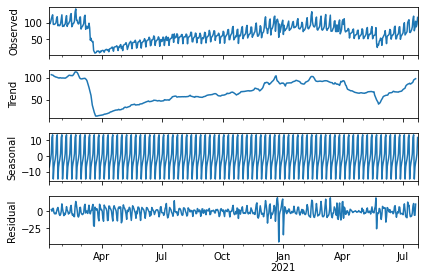

In [38]:
# Graficamos descomposición de serie:
result = seasonal_decompose(serie_d, model="additive")
fig = result.plot()
plt.savefig("Image.png")
plt.show(fig)

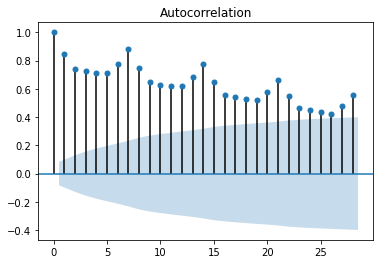

In [39]:
# Gráfico de ACF
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(serie_d)
plt.savefig("Image 1.f.png")
plt.show()

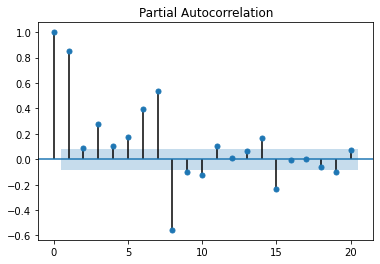

In [40]:
# Gráfico de PACF
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(serie_d, lags=20)
plt.savefig("Image 1g.png")
plt.show()

In [41]:
# Realizamos test Ljung-Box con lag=20
import statsmodels.api as sm
sm.stats.acorr_ljungbox(serie_d, lags=20)

# P valor para todos los lags es meor a 0,05, por lo tanto rejecteamos la H0 -> Hay al menos una correlacion distinta de 0

(array([ 402.57076618,  712.66838037, 1008.848006  , 1293.34672216,
        1577.42369536, 1920.48075015, 2359.53017535, 2678.10821719,
        2919.52940694, 3145.56504135, 3364.50278554, 3585.47749032,
        3850.9335639 , 4193.8997819 , 4436.47542737, 4615.02878996,
        4784.95253467, 4945.84795533, 5103.10706812, 5295.8091509 ]),
 array([1.51815319e-089, 1.76208757e-155, 2.16631565e-218, 9.21899809e-279,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000]))

In [42]:
# Diferenciamos la serie:

serie_d_dif=serie_d
serie_d_dif["Diferences"] = None


In [43]:
for i in range(0,(serie_d_dif.shape[0]-1)):
  serie_d_dif.iloc[(i+1),1]=serie_d_dif.iloc[(i+1),0] - serie_d_dif.iloc[i,0]

In [44]:
serie_d_dif.head()

,Value,Diferences
2020-01-13,100.00,None
2020-01-14,97.07,-2.93
2020-01-15,102.45,5.38
2020-01-16,111.21,8.76
2020-01-17,118.45,7.24


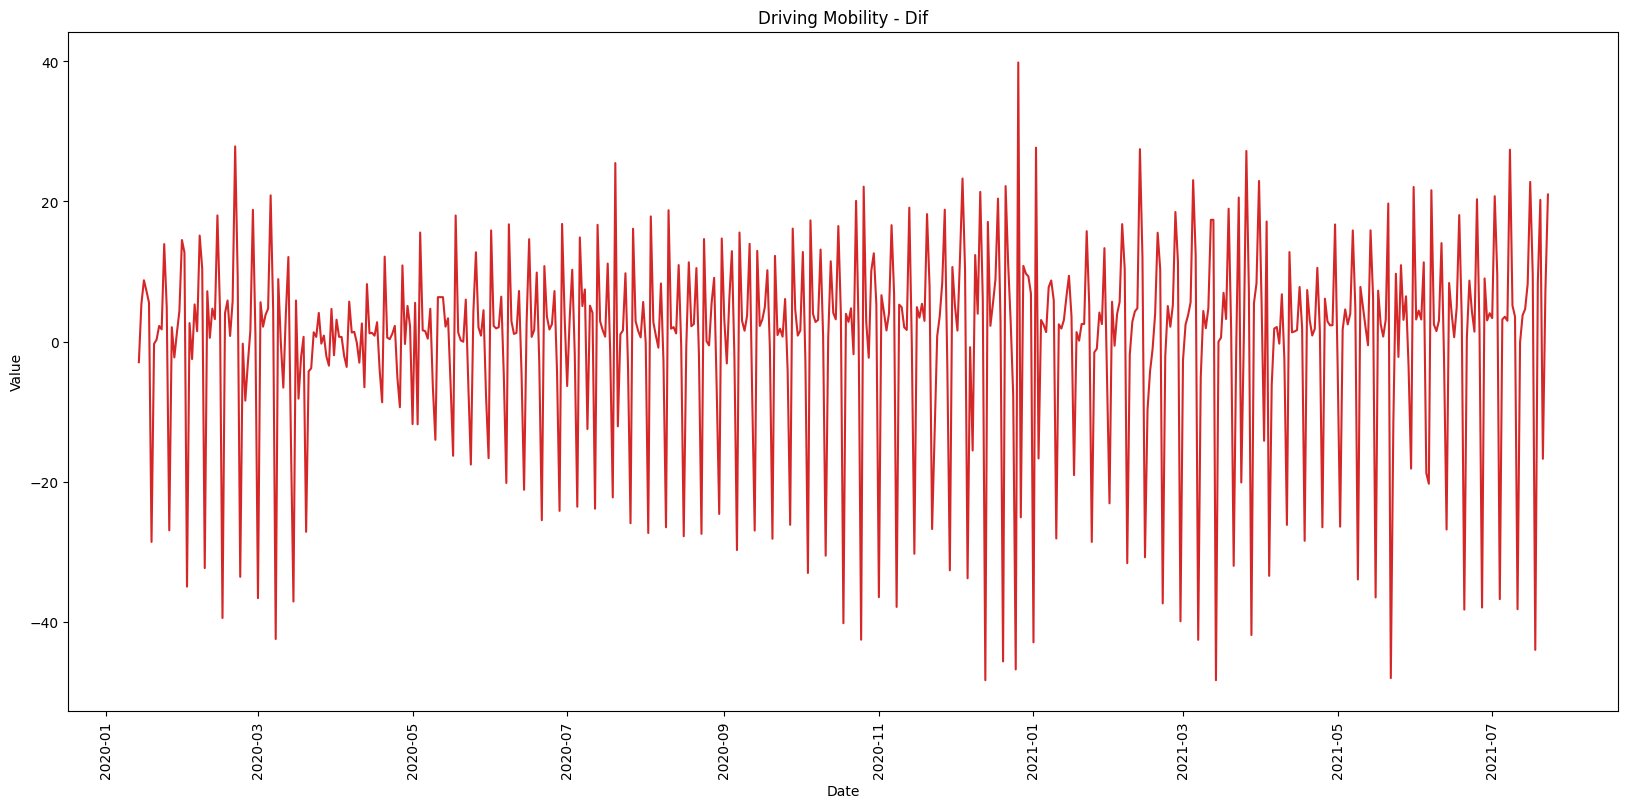

In [45]:
# Graficamos la serie diferenciada:
plot_data(serie_d_dif, x=serie_d_dif.index, y=serie_d_dif.Diferences, title='Driving Mobility - Dif')

In [46]:
# Convertimos en array para realizar tests de estacionariedad
serie_d_dif_array = serie_d_dif.iloc[1:, 1].values

In [47]:
# Test KPSS
kpss_test(serie_d_dif_array)

KPSS Statistic: 0.14218559201242406
p-value: 0.1
num lags: 19
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value



In [48]:
# Test ADF
adf_test(serie_d_dif_array)

ADF Statistic: -5.465193482171039
p-value: 2.4678154120289456e-06
Critial Values:
   1%, -3.4425861905056556
Critial Values:
   5%, -2.8669372502674824
Critial Values:
   10%, -2.5696445454608505
Result: The series is stationary


In [49]:
serie_d_dif=serie_d_dif["Diferences"].iloc[1:]
serie_d_dif=pd.DataFrame(serie_d_dif)

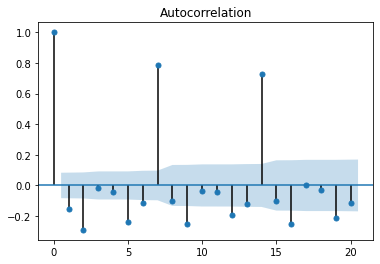

In [50]:
# Grafico de ACF
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(serie_d_dif.Diferences.tolist(), lags=20)
plt.savefig("Image 3.b.png")
plt.show()

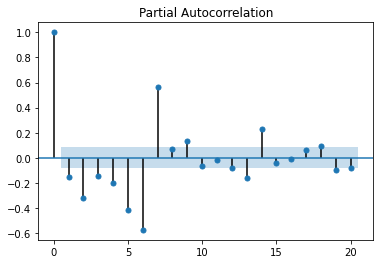

In [51]:
# Grafico de PACF
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(serie_d_dif.Diferences.tolist(), lags=20)
plt.savefig("Image 3.c.png")
plt.show()

In [52]:
# Test de Ljung Box:
sm.stats.acorr_ljungbox(serie_d_dif.Diferences.tolist(), lags=20)

(array([ 13.28769833,  60.55218334,  60.72106833,  61.64452195,
         92.91087696, 100.74291523, 450.0951725 , 456.16352528,
        492.35045195, 493.0892867 , 494.26261805, 515.35384602,
        523.59697849, 826.01876383, 831.82819381, 868.81810772,
        868.82448163, 869.39500118, 894.7741143 , 902.31780684]),
 array([2.67153254e-004, 7.10003444e-014, 4.12269063e-013, 1.30855859e-012,
        1.64257051e-018, 1.75603120e-019, 4.23657172e-093, 1.76682794e-093,
        2.49667515e-100, 1.32271870e-099, 5.36416821e-099, 1.19400684e-102,
        1.41626838e-103, 2.99965503e-167, 1.34591524e-167, 1.28364563e-174,
        9.58910190e-174, 5.26379383e-173, 1.46142793e-177, 2.52413047e-178]))

In [53]:
#Instalamos otras librerias:
import statsmodels.api

In [54]:
!pip install pmdarima
import pmdarima as pm

     |████████████████████████████████| 1.5 MB 7.5 MB/s 
     |████████████████████████████████| 9.5 MB 49.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [55]:
!pip install statsmodels

In [56]:

# Hacemos busqueda del mejor modelo SARIMA:
stepwise_fit = pm.auto_arima(serie_d.Value, start_p=1, start_q=1, max_p=10, max_q=10, m=7,
                             start_P=0, seasonal=True, d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=3811.001, Time=0.59 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=3999.509, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=3902.428, Time=0.33 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=3834.637, Time=0.32 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=inf, Time=0.48 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=1.27 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=3794.902, Time=1.66 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=inf, Time=4.48 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=3821.186, Time=1.03 sec
 ARIMA(1,1,0)(0,1,2)[7]             : AIC=3837.110, Time=1.30 sec
 ARIMA(2,1,1)(0,1,2)[7]             : AIC=3792.465, Time=2.53 sec
 ARIMA(2,1,1)(0,1,1)[7]             : AIC=3805.942, Time=0.80 sec
 ARIMA(2,1,1)(1,1,2)[7]             : AIC=inf, Time=5.52 sec
 ARIMA(2,1,1)(1,1,1)[7]             : AIC=inf, Time=2.00 sec
 ARIMA(2,1,0)(0,1,2)[7]             : AIC=3802.258, Time=1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  558
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 7)   Log Likelihood               -1888.866
Date:                           Fri, 30 Jul 2021   AIC                           3787.732
Time:                                   05:34:25   BIC                           3809.282
Sample:                                        0   HQIC                          3796.154
                                           - 558                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2522      0.030     -8.396      0.000      -0.311      -0.193
ma.L2         -0.2744      0.036     -7.684      0.000      -0.344      -0.204
ma.S.L7       -0.6099      0.023    -26.950      0.000      -0.654      -0.566
ma.S.L14      -0.1994      0.027     -7.293      0.000      -0.253      -0.146
sigma2        55.5897      1.182     47.023      0.000      53.273      57.907
===================================================================================
Ljung-Box (Q):                       45.71   Jarque-Bera (JB):              8414.76
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                            -2.37
Prob(H) (two-sided):                  0.02   Kurtosis:                        21.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
serie_d=serie_d.drop("Diferences", axis=1)

In [58]:
# Dividimos en train y test:
train = serie_d.loc['2020-01-13':'2021-03-31']
test = serie_d.loc['2021-04-01':'2021-07-23']

In [59]:
# Entrenamos:
stepwise_fit.fit(train)

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 1, 2, 7),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [60]:
# Predecimos:
future_forecast = stepwise_fit.predict(n_periods=len(test))


In [61]:
print(future_forecast)

[ 99.91628251 112.28830502 121.54376383  82.4979182   84.85600938
  89.77851058 102.12576461 102.86864179 117.24207939 126.25856204
  89.27456834  90.13530229  95.60568513 100.61521821 102.88704356
 119.2513965  128.26787916  91.28388545  92.14461941  97.61500224
 102.62453533 104.89636068 121.26071362 130.27719627  93.29320257
  94.15393652  99.62431936 104.63385244 106.90567779 123.27003073
 132.28651338  95.30251968  96.16325363 101.63363647 106.64316955
 108.91499491 125.27934785 134.2958305   97.3118368   98.17257075
 103.64295359 108.65248667 110.92431202 127.28866496 136.30514761
  99.32115391 100.18188786 105.6522707  110.66180378 112.93362913
 129.29798207 138.31446473 101.33047102 102.19120498 107.66158782
 112.6711209  114.94294625 131.30729919 140.32378184 103.33978814
 104.20052209 109.67090493 114.68043801 116.95226336 133.3166163
 142.33309895 105.34910525 106.2098392  111.68022204 116.68975512
 118.96158048 135.32593342 144.34241607 107.35842237 108.21915632
 113.689539

In [62]:
# Graficamos la comparación:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=["Prediction"])
comparison = pd.concat([test,future_forecast],axis=1)

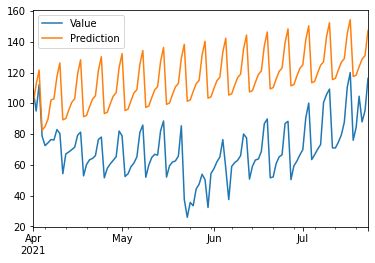

In [63]:
comparison.plot()
plt.savefig("Model 1.a.png")

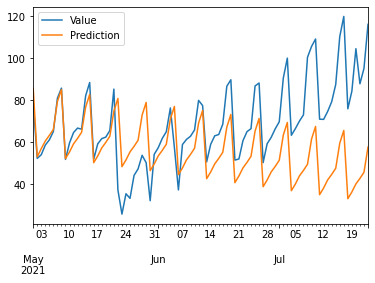

In [64]:
# HAcemos lo mismo para otros periodos de train y test:
train = serie_d.loc['2020-01-13':'2021-04-30']
test = serie_d.loc['2021-05-01':'2021-07-23']
stepwise_fit.fit(train)
future_forecast_2 = stepwise_fit.predict(n_periods=len(test))
future_forecast_2 = pd.DataFrame(future_forecast_2,index = test.index,columns=["Prediction"])
comparison_2 = pd.concat([test,future_forecast_2],axis=1)
comparison_2.plot()
plt.savefig("Model 1.b.png")

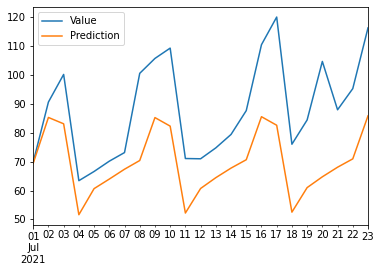

In [65]:
# HAcemos lo mismo para otros periodos de train y test:
train = serie_d.loc['2020-01-13':'2021-06-30']
test = serie_d.loc['2021-07-01':'2021-07-23']
stepwise_fit.fit(train)
future_forecast_2 = stepwise_fit.predict(n_periods=len(test))
future_forecast_2 = pd.DataFrame(future_forecast_2,index = test.index,columns=["Prediction"])
comparison_2 = pd.concat([test,future_forecast_2],axis=1)
comparison_2.plot()
plt.savefig("Model 1.c.png")

In [66]:
# Ampliamos la busqueda del modelo:
stepwise_fit_2 = pm.auto_arima(serie_d.Value, start_p=1, start_q=1, max_p=10, max_q=10, m=7,
                             start_P=0,max_P=10, seasonal=True, d=1, D=1, max_D=10, max_d=10, start_Q=1, max_Q=10, trace=True, with_intercept=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True,
                             maxiter=100)  # set to stepwise

stepwise_fit_2.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7] intercept   : AIC=3812.897, Time=1.19 sec
 ARIMA(0,1,0)(0,1,0)[7] intercept   : AIC=4001.507, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[7] intercept   : AIC=3904.423, Time=0.60 sec
 ARIMA(0,1,1)(0,1,1)[7] intercept   : AIC=3836.600, Time=0.61 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=3999.509, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[7] intercept   : AIC=inf, Time=1.19 sec
 ARIMA(1,1,1)(1,1,1)[7] intercept   : AIC=inf, Time=2.87 sec
 ARIMA(1,1,1)(0,1,2)[7] intercept   : AIC=3796.569, Time=4.31 sec
 ARIMA(1,1,1)(1,1,2)[7] intercept   : AIC=inf, Time=8.39 sec
 ARIMA(1,1,1)(0,1,3)[7] intercept   : AIC=3791.936, Time=8.82 sec
 ARIMA(1,1,1)(1,1,3)[7] intercept   : AIC=inf, Time=16.53 sec
 ARIMA(1,1,1)(0,1,4)[7] intercept   : AIC=inf, Time=12.67 sec
 ARIMA(1,1,1)(1,1,4)[7] intercept   : AIC=inf, Time=21.54 sec
 ARIMA(0,1,1)(0,1,3)[7] intercept   : AIC=3819.232, Time=4.48 sec
 ARIMA(1,1,0)(0,1,3)[7] intercept   : AIC=3835.738, Time=3.7

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  558
Model:             SARIMAX(0, 1, 2)x(0, 1, 3, 7)   Log Likelihood               -1885.029
Date:                           Fri, 30 Jul 2021   AIC                           3782.059
Time:                                   05:47:40   BIC                           3807.918
Sample:                                        0   HQIC                          3792.164
                                           - 558                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2490      0.029     -8.550      0.000      -0.306      -0.192
ma.L2         -0.2801      0.036     -7.713      0.000      -0.351      -0.209
ma.S.L7       -0.6330      0.024    -26.633      0.000      -0.680      -0.586
ma.S.L14      -0.1162      0.036     -3.261      0.001      -0.186      -0.046
ma.S.L21      -0.1325      0.032     -4.188      0.000      -0.194      -0.070
sigma2        54.5749      1.420     38.436      0.000      51.792      57.358
===================================================================================
Ljung-Box (Q):                       45.87   Jarque-Bera (JB):              8076.09
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                            -2.32
Prob(H) (two-sided):                  0.03   Kurtosis:                        21.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

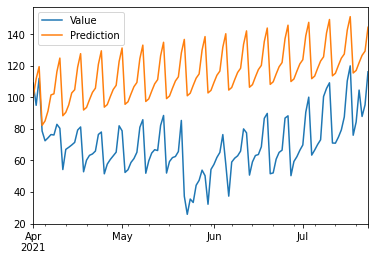

In [67]:
# Entrenamos, testeamos y graficamos:
train = serie_d.loc['2020-01-13':'2021-03-31']
test = serie_d.loc['2021-04-01':'2021-07-23']
stepwise_fit_2.fit(train)
future_forecast_3 = stepwise_fit_2.predict(n_periods=len(test))
future_forecast_3 = pd.DataFrame(future_forecast_3,index = test.index,columns=["Prediction"])
comparison_3 = pd.concat([test,future_forecast_3],axis=1)
comparison_3.plot()
plt.savefig("Model 2.a.png")

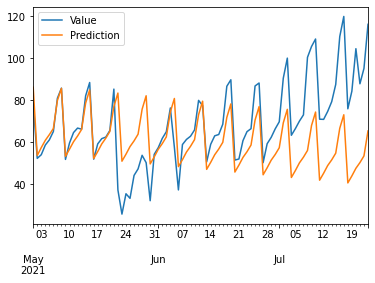

In [68]:
# Entrenamos, testeamos y graficamos para otros periodos:
train = serie_d.loc['2020-01-13':'2021-04-30']
test = serie_d.loc['2021-05-01':'2021-07-23']
stepwise_fit_2.fit(train)
future_forecast_3 = stepwise_fit_2.predict(n_periods=len(test))
future_forecast_3 = pd.DataFrame(future_forecast_3,index = test.index,columns=["Prediction"])
comparison_3 = pd.concat([test,future_forecast_3],axis=1)
comparison_3.plot()
plt.savefig("Model 2.b.png")

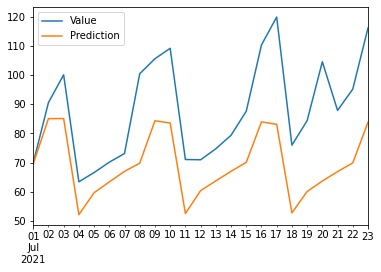

In [69]:
# Entrenamos, testeamos y graficamos para otros periodos:
train = serie_d.loc['2020-01-13':'2021-06-30']
test = serie_d.loc['2021-07-01':'2021-07-23']
stepwise_fit_2.fit(train)
future_forecast_4 = stepwise_fit_2.predict(n_periods=len(test))
future_forecast_4 = pd.DataFrame(future_forecast_4,index = test.index,columns=["Prediction"])
comparison_4 = pd.concat([test,future_forecast_4],axis=1)
comparison_4.plot()
plt.savefig("Model 2.c.png")

In [70]:
ord = (1, 1, 2)
seasonal_ord = (1, 1, 3, 7)

In [71]:
# Probamos otro modelo con p > 0 pero no funciona mejor:
sarima_m = pm.arima.arima.ARIMA(maxiter=100, method='lbfgs', order=(2, 1, 2), out_of_sample_size=0, scoring='mse', scoring_args={}, seasonal_order=(2, 1, 3, 7), start_params=None, suppress_warnings=True, trend="t", with_intercept=False)

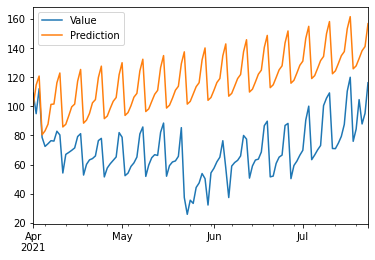

In [72]:
train = serie_d.loc['2020-01-13':'2021-03-31']
test = serie_d.loc['2021-04-01':'2021-07-23']
sarima_m.fit(train)
future_forecast_4 = sarima_m.predict(n_periods=len(test))
future_forecast_4 = pd.DataFrame(future_forecast_4,index = test.index,columns=["Prediction"])
comparison_4 = pd.concat([test,future_forecast_4],axis=1)
comparison_4.plot()
plt.savefig("Model 2.c.png")

In [73]:
dates_predict = pd.date_range("2021-07-24","2021-08-22",freq='d')

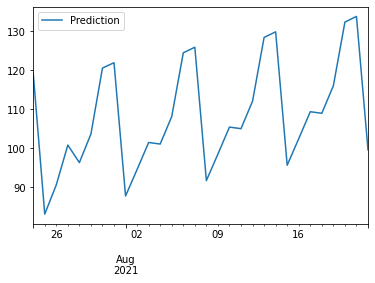

In [74]:
# Predicción:
train = serie_d.loc['2020-01-13':'2021-07-23']
stepwise_fit.fit(train)
future_forecast_2 = stepwise_fit.predict(n_periods=30)
future_forecast_2 = pd.DataFrame(future_forecast_2,index = dates_predict, columns=["Prediction"])
future_forecast_2.plot()
plt.savefig("Prediccion Mobilidad.png")

In [76]:
future_forecast_2.to_csv("/content/sample_data/prediccion_mobilidad.csv")